## Streamed vs. Merged networks

For both experiments we divide the data in $4$ partitions (exactly the same across the experiments).

1. Streaming:
    1. Calculate netowork for the first partition
    1. For each partition perform NN on the network
    1. Data points from partition are added to the resulting nearest anchors
    1. Merge the resulting networks (each network has the same anchors)
    
2. Merging
    1. Calculate network for each partition
    2. Merge by calculating network over partition network anchors

In [20]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import pickle
import matplotlib.pyplot as plt

from scipy.stats import linregress

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [5]:
with open('../res/9003-stream-nets.pickle', 'rb') as f:
    st_nets = pickle.load(f)

In [33]:
d_size = sum(map(sum, nets[0.0][0].values()))
comp = {gamma: len(voting)/d_size for gamma, [merged, voting] in st_nets.items()}
comp_mer = {gamma: len(voting)/d_size for gamma, [merged, voting] in nets.items()}

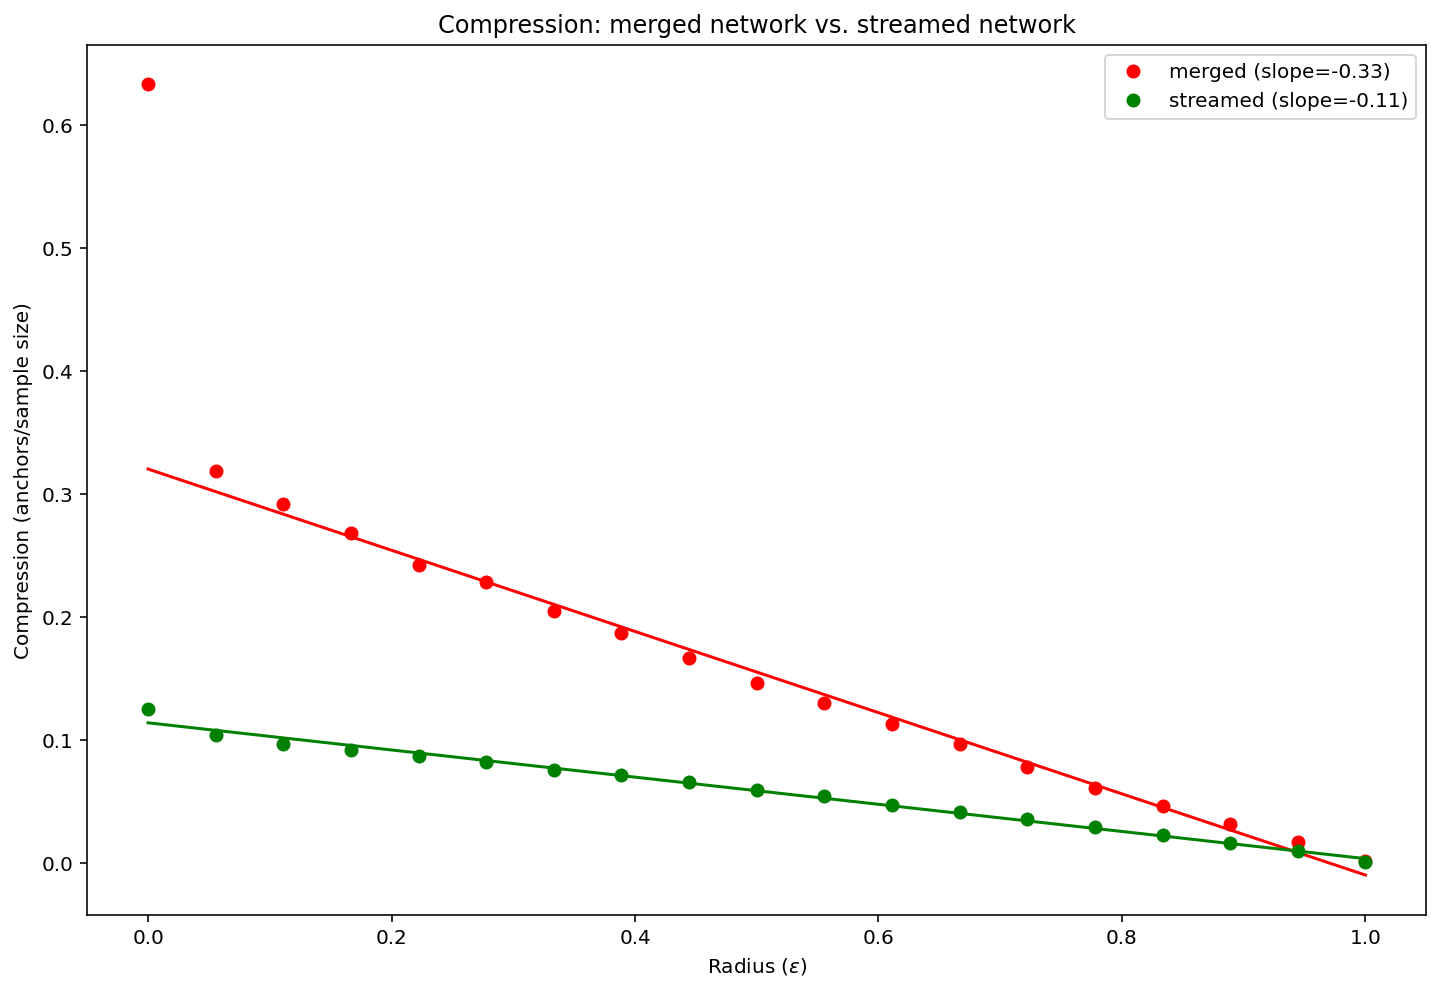

In [51]:

x1 = np.array(list(comp.keys()))
y1 = list(comp.values())
res1 = linregress(x1, y1)

x2 = np.array(list(comp_mer.keys()))
y2 = list(comp_mer.values())
res2 = linregress(x2[1:], y2[1:])

plt.figure(figsize=(12,8))
plt.title('Compression: merged network vs. streamed network')
plt.plot(x2,y2, 'o',c='r', label=f"merged (slope={res2.slope:.2f})")
plt.plot(x2, res2.intercept + res2.slope*x2, c='r')

plt.plot(x1, y1,'o',c='g', label=f"streamed (slope={res1.slope:.2f})")
plt.plot(x1, res1.intercept + res1.slope*x1, c='g')

plt.ylabel('Compression (anchors/sample size)')
plt.xlabel("Radius ($\epsilon$)")
plt.legend();

In [45]:
single_nets = dict()
for gamma in st_nets.keys():
    with open(f"../res/{gamma}-tc-singlevoting.pickle", 'rb') as f:
        nw = pickle.load(f)
        single_nets[gamma] = nw[gamma]
single_sizes = {g:len(a[0]) for g, a in single_nets.items()}
stream_sizes = {gamma: len(voting) for gamma, [merged, voting] in st_nets.items()}

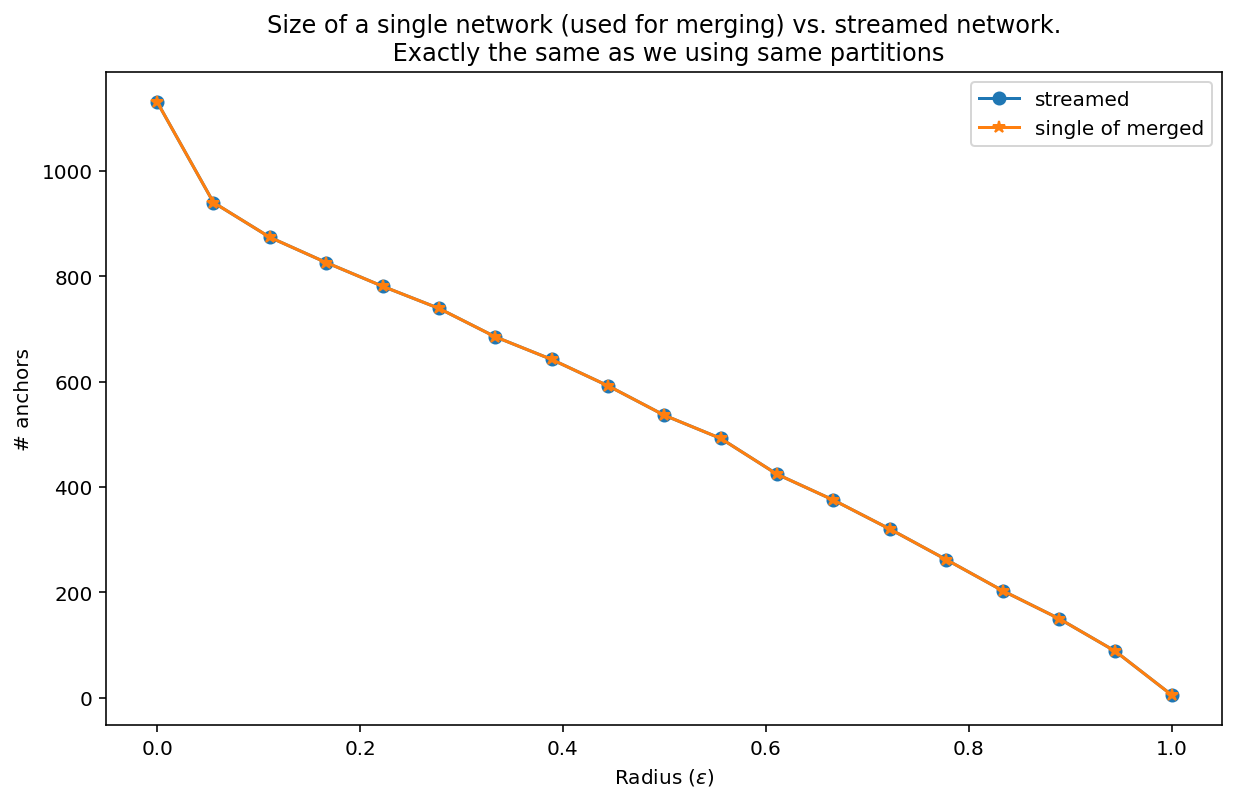

In [52]:
plt.figure(figsize=(10,6))
plt.title('Size of a single network (used for merging) vs. streamed network.\n Exactly the same as we using same partitions')
plt.plot(list(stream_sizes.keys()), list(stream_sizes.values()),'-o', label='streamed')
plt.plot(list(single_sizes.keys()), list(single_sizes.values()), '-*', label='single of merged')
plt.ylabel('# anchors')
plt.xlabel("Radius ($\epsilon$)")
plt.legend();

In [14]:
## Performance

In [15]:
with open('../res/tc-new-mer.pickle', 'rb') as f:
    res_mer = pickle.load(f)

with open('../res/tc-stream-probs.pickle', 'rb') as f:
    res_str = pickle.load(f)

In [17]:
gammas = list(res_mer.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, res_str[gamma])
    roc_auc1 = roc_auc_score(true_vals, probs) 
    
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = roc_auc_score(true_vals, res_str[gamma])

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2]

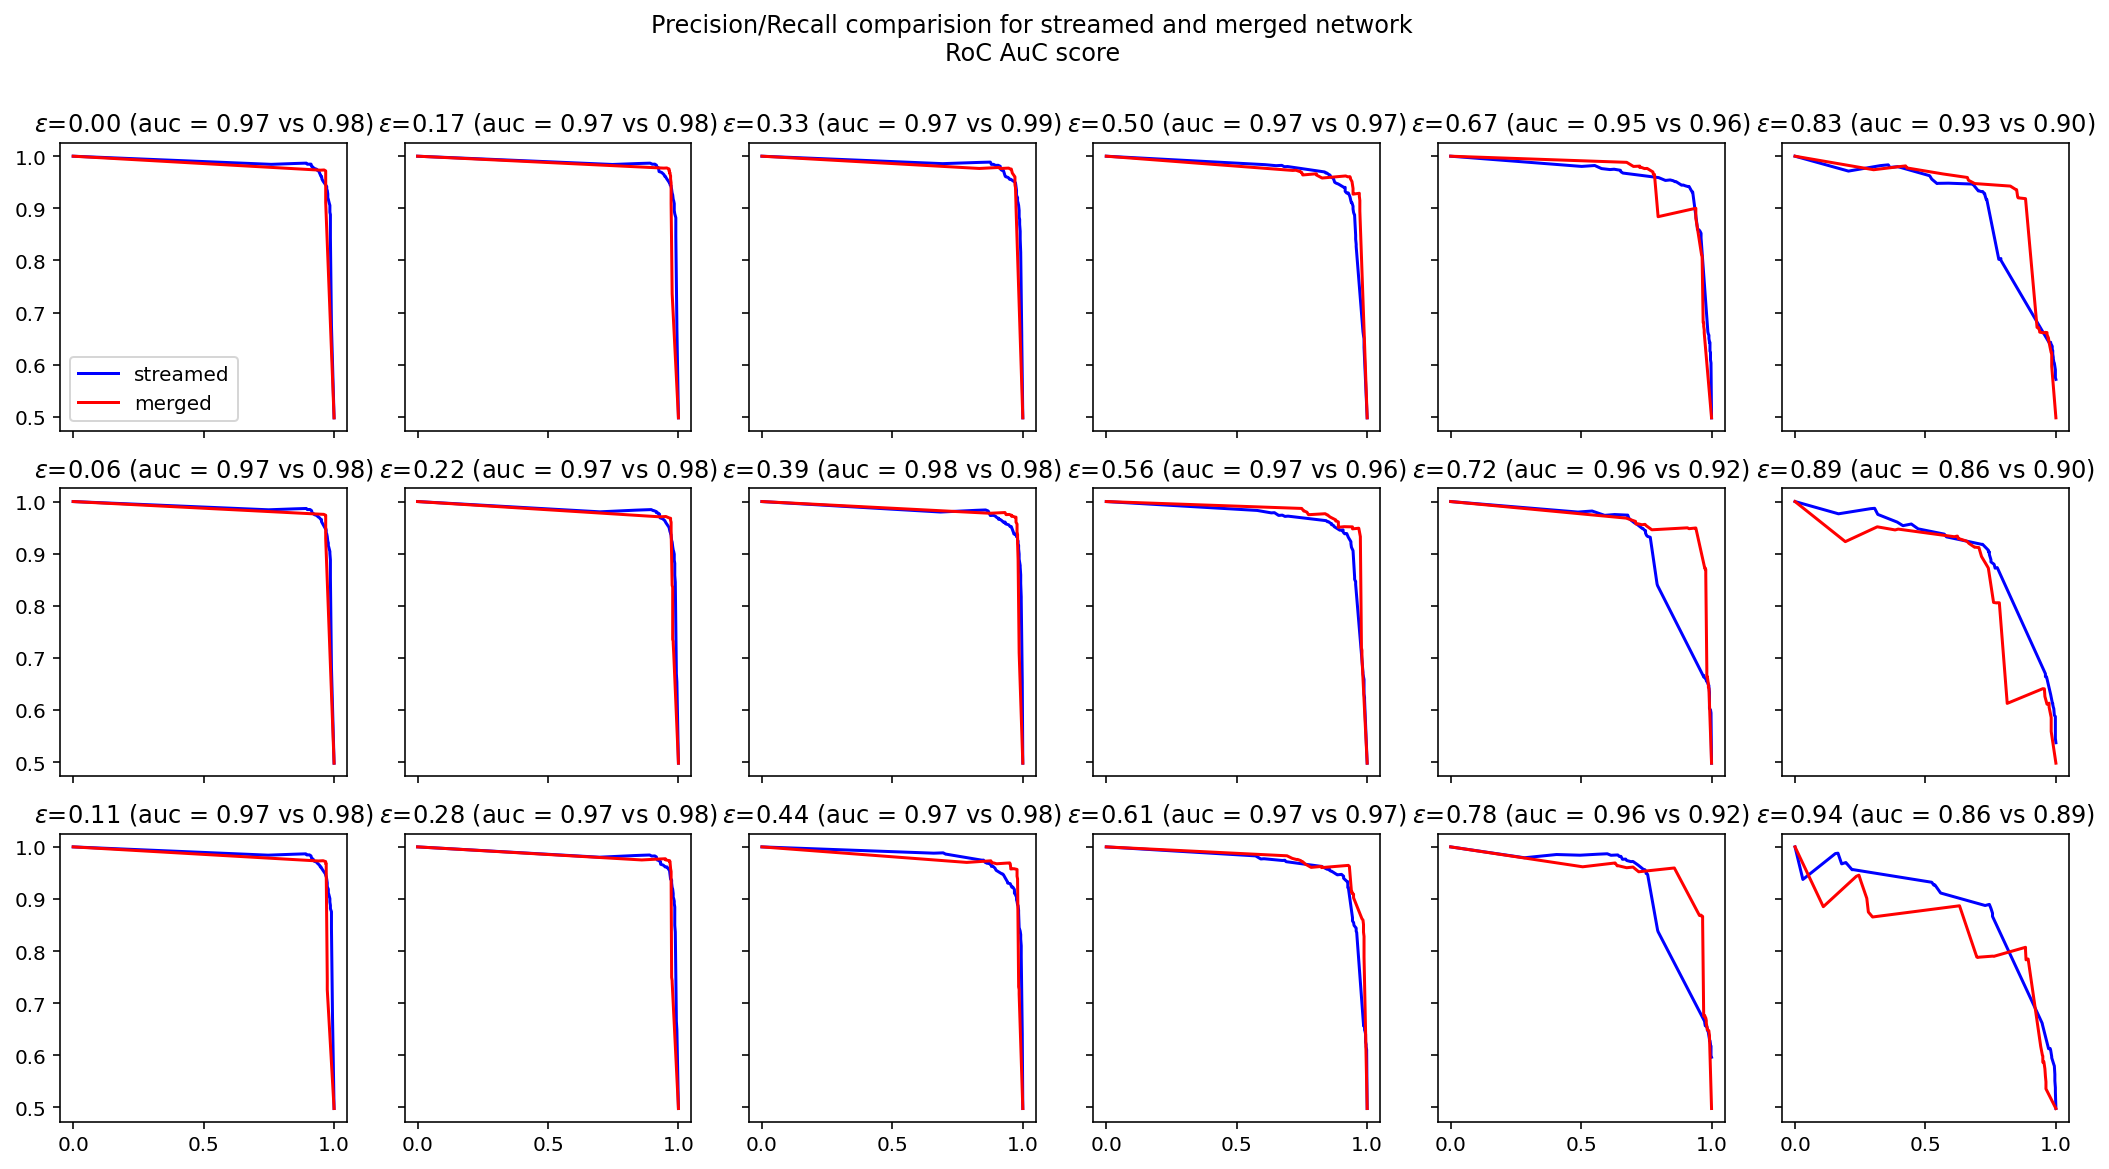

In [53]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network\nRoC AuC score')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='streamed')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].set_title(f"$\epsilon$={gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();